# Setup

In [1]:
import numpy as np
import tensorflow as tf
import os
import sys

# import functions and datasets from our Git repo
!git clone "https://github.com/RiccardoCozzi96/DeepComedy"
sys.path.append("DeepComedy/tokenizer/")
sys.path.append("DeepComedy/metrics/")
sys.path.append("DeepComedy/datasets/")

# select destination folderss
use_drive = False
if use_drive:
  from google.colab import drive
  drive.mount('/content/gdrive')
  path = "/content/gdrive/My Drive/DeepComedyGenerated/" 
else:
  path = "/DeepComedyGenerated/"
  
datasets_path = "DeepComedy/datasets"

# create destination folder if it doesn't exist
if not os.path.exists(path):
  os.mkdir(path)
  print("CREATED: ", path)

Cloning into 'DeepComedy'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 442 (delta 10), reused 0 (delta 0), pack-reused 421
Receiving objects: 100% (442/442), 2.58 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (71/71), done.
CREATED:  /DeepComedyGenerated/


#Set Hyperparameters

In [2]:
# ATTENTION: assert d_model % self.num_heads == 0

num_layers_encoder = 5
num_layers_decoder = 5

d_model = 256
dff = 512
num_heads = 4
dropout_rate = 0.2

# One epoch is all you need
epochs_production = 0
epochs_comedy = 1

# number of repetitions per dataset, instead of epochs
repetitions_production = 0
repetitions_comedy = 70

# append files' names in the desired order
myorder = []
if epochs_production > 0:
  # Sort files lists in custom order
  production_list = ['tokenized_convivio.txt','tokenized_vita.txt', 'tokenized_detto.txt','tokenized_fiore.txt']
  for filename in production_list:
    myorder.append(filename)
if epochs_comedy > 0:
  myorder.append('tokenized_commedia.txt')
print("myorder: ", myorder)

myorder:  ['tokenized_commedia.txt']


# Load Data

In [3]:
# Read files and save them in list_of_lists
def read_files(directory):
  files_list = []
  files_names = []
  for filename in os.listdir(directory):
      if filename.endswith(".txt"):
 
          path_to_file = os.path.join(directory, filename)
 
          # Read file
          text = open(path_to_file, 'r').read().lower()
 
          # generate list from text by splitting lines
          text_list = text.splitlines()
          files_list.append(text_list)
          files_names.append(filename)
      else:
          continue
 
  return files_list, files_names

directory = './DeepComedy/datasets/tokenized/'
files_list, files_names = read_files(directory)

# Functions Definitions

## Text Processing

In [4]:
# Flattens list
def flatten(data):
  return [token for verse in data for token in verse]

# Replaces special tokens with more readable ones
def clear_text(text):
  return text.replace('<s>', ' ').replace('<v>', '').replace('<t>','\n').replace('</v>', '\n').replace('~', ' ')

In [5]:
# Creates list of tokens from input string with tokens
def split_tokens(data):
  split = []
  for verse in data:
    split.append(verse.split(' '))
  return split

# Encodes tokens by using the vocabulary
def encode_tokens(data):
  encoded = []
  for verse in data:
    encoded.append(text_list_to_int(verse))
  return encoded

In [6]:
# Create vocabulary and mappings
def create_vocab(files, myorder):
  # flatten list_of_lists to list of tokens
  flattened = []
  for i, file_name in enumerate(files):
    if file_name in myorder:
      flattened.extend(flatten(split_tokens(files[file_name])))
  
  # create vocabulary
  tokens_set = set(flattened)

  # append punctuation to head of vocabulary
  non_alphas = []
  alphas = []
  for token in tokens_set:
    if not token.isalpha():
      non_alphas.append(token)
    else:
      alphas.append(token)
  punctuation = []
  punctuated_syls = []
  special_tokens = []
  for token in non_alphas:
    if len(token) == 1:
      punctuation.append(token)
    elif '<' in token:
      special_tokens.append(token)
    else:
      punctuated_syls.append(token)

  # follow with the rest of the tokens
  alphas.extend(punctuated_syls)
  alphas = sorted(alphas, key=len)
  vocab = []
  for group in [special_tokens, punctuation, alphas]:
    vocab.extend(group)

  # if missing, add empty string at position 0
  if '' in vocab:
    vocab.remove('')
  vocab.insert(0, '')

  vocab_size = len(vocab)

  # Creating a mapping from unique characters to indices
  str2idx = {u:i for i, u in enumerate(vocab)}
  idx2str = np.array(vocab)

  print("\n\nvocabulary size: {} tokens".format(vocab_size))
  print("\nstr2idx:\n", str2idx)
  print("\nidx2str:\n", idx2str)
  return vocab_size, str2idx, idx2str

# Converts our text values to numeric.
def text_list_to_int(string_list):
  return np.array([str2idx[c] for c in string_list])
 
# Converts our numeric values to text.
def ints_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2str[ints])

## Split Input Target

In [7]:
def create_dataset(inputs, targets, batch_size = 64, repetitions = 100):
  # Create dataset from inputs and targets
  dataset = tf.data.Dataset.from_tensor_slices((
      tf.keras.preprocessing.sequence.pad_sequences(inputs), 
      tf.keras.preprocessing.sequence.pad_sequences(targets)))
  # cache the dataset to memory to get a speedup while reading from it.
  dataset = dataset.cache()
  # create batched dataset and shuffle it
  buffer_size = len(dataset)
  dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True).repeat(repetitions).padded_batch(batch_size, drop_remainder=True)
  # This allows later elements to be prepared while the current is being processed.
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return buffer_size, dataset

In [8]:
# split dataset in input-target couples
def split_input_target_comedy(text_list, inp_len=3, tar_len=4, skip=1, 
                              batch_size=64, repetitions=100):
  
  inputs = []
  targets = []

  # Prepare data for model (list of integers)
  dataset = split_tokens(text_list)
  dataset = encode_tokens(dataset)
  
  # Split input-target
  for i in range(0, len(dataset)-tar_len, skip):
    inputs.append(flatten(dataset[i:i+inp_len]))
    targets.append(flatten(dataset[i:i+tar_len]))

  # Max length of Divine Comedy verses
  max_len = max(len(x) for x in inputs)

  # Create repeated, shuffled and prefetched dataset
  real_size, dataset = create_dataset(inputs, targets, batch_size, repetitions)
 
  # Real dataset size (not repeated)
  real_size_batched = int(real_size/batch_size)

  return dataset, max_len, real_size_batched

In [9]:
# split dataset in input-target couples
def split_input_target_production(datasets, inp_len=3, tar_len=3, skip=1, 
                                  batch_size=64, repetitions=100):
  
  datasets_list = []
  inputs = []
  targets = []

  for text_list in datasets:

    # Prepare data for model (list of integers)
    dataset = split_tokens(text_list)
    dataset = encode_tokens(dataset)
    
    # Split input-target
    for i in range(0, len(dataset)-tar_len, skip):
      inputs.append(flatten(dataset[i:i+inp_len]))
      targets.append(flatten(dataset[i:i+tar_len]))

  # Create repeated, shuffled and prefetched dataset
  real_size, dataset = create_dataset(inputs, targets, batch_size, repetitions)
 
  # Real dataset size (not repeated)
  real_size_batched = int(real_size/batch_size)

  return dataset, real_size_batched

# Datasets Creation

In [10]:
# Create files dictionary
files = {files_names[i]:files_list[i] for i in range(len(files_names))}

# Create vocabularies
vocab_size, str2idx, idx2str = create_vocab(files, myorder)

# Print files' names and texts
print("\n\n{}".format('='*100))
print("\nFiles: ", len(files))
print("Files names:")
for i, file_name in enumerate(files):
  print("\t{}- {}".format(i+1, file_name))
print("\n\n{}".format('='*100))



vocabulary size: 5164 tokens

str2idx:
 {'': 0, '<t>': 1, '<s>': 2, '</v>': 3, '<v>': 4, '"': 5, ',': 6, "'": 7, '?': 8, ':': 9, '!': 10, ';': 11, '.': 12, 'i': 13, 'm': 14, 'n': 15, 'b': 16, 'ò': 17, 'u': 18, 'é': 19, 'l': 20, 'r': 21, 'e': 22, 'ì': 23, 'ó': 24, 'c': 25, 'è': 26, 'ù': 27, 't': 28, 'p': 29, 'a': 30, 'd': 31, 'o': 32, 'à': 33, 'h': 34, 's': 35, 'bi': 36, 'nì': 37, 'ìn': 38, 'tè': 39, 'ee': 40, 'fà': 41, 'ti': 42, 'dò': 43, 'po': 44, 'pe': 45, 'ge': 46, 'sè': 47, 'de': 48, 'pè': 49, 'tù': 50, 'ùn': 51, 'va': 52, 'sé': 53, 'bà': 54, 'té': 55, 'eu': 56, 'cù': 57, 'be': 58, 'vó': 59, 'zè': 60, 'am': 61, 'so': 62, 'fó': 63, 'ev': 64, 'ie': 65, 'én': 66, 'of': 67, 'só': 68, 'ès': 69, 'zo': 70, 'àt': 71, 'hi': 72, 'io': 73, 'ce': 74, 've': 75, 'fù': 76, 'ir': 77, 'ém': 78, 'go': 79, 'ùr': 80, 'mì': 81, 'fu': 82, 'ob': 83, 'có': 84, 'iu': 85, 'un': 86, 'fì': 87, 'pé': 88, 'gi': 89, 'tu': 90, 'ma': 91, 'af': 92, 'dó': 93, 'ré': 94, 'dé': 95, 'az': 96, 'me': 97, 'pu': 98, 'ur':

In [11]:
# Create Dante's Produciton datasets list
dataset_production = []
for file_name in myorder:
  if not file_name == "tokenized_commedia.txt":
    dataset_production.append(files[file_name])
  
# Split input target for Dante's Production dataset
if epochs_production > 0:
  print("Generating Dante's Production")
  dataset_production, real_size_production = split_input_target_production(
      dataset_production, inp_len = 3, tar_len = 3, repetitions = repetitions_production)
  print("Real size production: ", real_size_production)


# Split input target for Divine Comedy dataset
if epochs_comedy > 0:
  print("Generating Divine Comedy")
  dataset_comedy, max_len, real_size_comedy = split_input_target_comedy(
          text_list = files["tokenized_commedia.txt"], inp_len = 3, tar_len = 4, repetitions = repetitions_comedy)
  print("Real size comedy: ", real_size_comedy)

Generating Divine Comedy
Real size comedy:  223


In [12]:
# Print samples of the generated Comedy dataset
print("Comedy datasets Samples:\n")
for (batch, (inputs, targets)) in enumerate(dataset_comedy.take(1)):
  print("{} [batch: {}] {}".format("="*15, batch, "="*15))
  print("-- input:\n\n{}\n\n-- target:\n\n{}\n".format(clear_text(ints_to_text(inputs[0])),clear_text(ints_to_text(targets[0]))))

Comedy datasets Samples:

=============== [batch: 0] ===============
-- input:


o iacopo, dicea, da sànto andrea,
ché t'è giovàto di me fàre schermo?
ché cólpa ho io de la tua vìta rea?.


-- target:


o iacopo, dicea, da sànto andrea,
ché t'è giovàto di me fàre schermo?
ché cólpa ho io de la tua vìta rea?.

quàndo 'l maestro fu sovr'esso fermo,




# Transformer Components and Functions

## Positional encoding


Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [13]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [14]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [15]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [16]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [17]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [18]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [20]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard sequence to sequence with attention model. 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [23]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero= True)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [24]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model, mask_zero= True)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Transformer

In [25]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers_encoder, num_layers_decoder, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers_encoder, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers_decoder, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [27]:
# Sparse Categorical Crossentropy loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [28]:
def loss_function(real, pred):
  # "mask" is a boolean tensor with False values on padding values (0 values) 
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  # "loss_" is a tensor of float values
  loss_ = loss_object(real, pred)
  # convert mask boolean values to float (False=0. and True=1.)
  mask = tf.cast(mask, dtype=loss_.dtype)
  # apply mask to loss tensor
  loss_ *= mask
  
  # returns a single float value representing the loss value
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [29]:
# training metrics definition
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Transformer instantiation


In [30]:
# trainsformer model instantiation
transformer = Transformer(num_layers_encoder, num_layers_decoder,
                          d_model, num_heads, dff,
                          input_vocab_size= vocab_size,
                          target_vocab_size= vocab_size,
                          pe_input= vocab_size, 
                          pe_target= vocab_size,
                          rate= dropout_rate)

# Training


## Functions Definition

In [31]:
# prints model training progress
def print_progress(done:int, total:int, *args):
  maxlen = 25
  bars = round(done*maxlen/total)
  print("\r[{}{}] {:3}%".format("="*int(bars),
                                " "*int((maxlen - bars)),
                                round(done*100/total)), 
        end="\t {:>5}/{:<5}\t{}\t".format(done,
                                          total,
                                          [str(a) for a in args]))

In [32]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.
 
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
 
  pred_size = 1
  # split input and target
  tar_inp = tar[:, :-pred_size]
  tar_real = tar[:, pred_size:]
 
  # create masks
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  # compute predictions
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp,
                                 tar_inp, 
                                 True, 
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask
                                 )
 
    # compute loss function
    loss = loss_function(tar_real, predictions)
  
  # compute gradients
  gradients = tape.gradient(loss, transformer.trainable_variables)    
 
  # apply gradients
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
 
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [33]:
import time
 
def train_model(dataset, epochs, real_size):

  start = time.time()
  
  repetition = 1
  
  loss_history = []
  accuracy_history = []

  for epoch in range(epochs):
    
    repetitions = int(len(dataset)/real_size)

    for (batch, (inp, tar)) in enumerate(dataset):
            
      train_step(inp, tar)
 
      print_progress(batch, len(dataset), 
                    "epoch {}/{}   repetition {}/{}  loss: {:.4f}  accuracy: {:.4f}".format(
                        epoch+1, epochs, repetition, repetitions, train_loss.result(), train_accuracy.result()))

      # at each repetition "epoch"
      if batch != 0 and (batch) % real_size == 0:
        # Append values to histories
        loss_history.append('{:.4f}'.format(train_loss.result()))
        accuracy_history.append('{:.4f}'.format(train_accuracy.result()))
        # Reset loss and accuracy states
        train_loss.reset_states()
        train_accuracy.reset_states()
        repetition +=1
  
  # Append last values to histories
  loss_history.append('{:.4f}'.format(train_loss.result()))
  accuracy_history.append('{:.4f}'.format(train_accuracy.result()))

  t = round(time.time() - start)
  print(f'\n\tTraining completed in {int(t/3600)}h {int(t/60%60)}m {int(t%60)}s.\n')
  
  return t, loss_history, accuracy_history

## Actual Training

In [34]:
print(f"Training model:\n - encoders: {num_layers_encoder}\n - decoders: {num_layers_decoder}\n - d_model: {d_model}\n - dff: {dff}\n - num_heads: {num_heads}\n - dropout_rate: {dropout_rate}")

Training model:
 - encoders: 5
 - decoders: 5
 - d_model: 256
 - dff: 512
 - num_heads: 4
 - dropout_rate: 0.2


In [35]:
# Train on Dante's production
if epochs_production > 0:
  t_production, loss_hist_production, acc_hist_production = train_model(dataset_production, epochs_production, real_size_production)
else:
  t_production = 0
  loss_hist_production = ["0"]
  acc_hist_production = ["0"]

In [36]:
# Train on divine comedy
if epochs_comedy > 0:
  t_comedy, loss_hist_comedy, acc_hist_comedy = train_model(dataset_comedy, epochs_comedy, real_size_comedy)
else:
  t_comedy = 0
  loss_hist_comedy = ["0"]
  acc_hist_comedy = ["0"]

[=========================] 100%	 15673/15674	['epoch 1/1   repetition 71/70  loss: 0.2627  accuracy: 0.7112']	
	Training completed in 0h 58m 38s.



# Text Generation

In [37]:
def evaluate(input, eov, max_length=100, temperature=1.0):
 
  # add the batch dimension for compatibility
  encoder_input = tf.expand_dims(input, 0)
  decoder_input = tf.expand_dims(input, 0)
 
  # the final output of the evaluation (initially, this is an empty list)
  output = []
 
  # we repeat the process to get the entire verse (end-of-verse token is predicted)
  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)  
    logits, attention_weights = transformer(
        encoder_input, decoder_input, False,
        enc_padding_mask, combined_mask, dec_padding_mask
    )
 
    # the higher the temperature, the more original (or crazy) is the text
    predictions = logits[: ,:, :]
    predictions /= temperature
    predicted_id = tf.cast(tf.random.categorical(tf.squeeze(predictions, 0), num_samples=1)[-1,0].numpy() , tf.int32)
    
    # append the predicted token to the output
    output.append(predicted_id)
 
    # if the token coincides with the end-of-verse token
    if predicted_id == eov:
      break
 
    # otherwise the token is appended both to the new decoder input
    decoder_input = tf.concat([decoder_input, [[predicted_id]]], axis=-1)
 
  return output, attention_weights

In [38]:
def generate(start, eov, max_len, max_iterations=5, temperature=1.0):

  # drop the first verse to keep a window of 3 verses
  def drop_first_verse(sequence):
    for i, element in enumerate(sequence):
      if element == str2idx['</v>']:
        return sequence[i+1:]

  # variables initialization
  input_sequence = start.copy()
  generated = []

  for i in range(max_iterations):

    # pad the input list to reach the max_len
    input_list = list(tf.keras.preprocessing.sequence.pad_sequences([input_sequence], maxlen=max_len)[0])

    # generate one verse
    generated_verse, _ = evaluate(input_list, eov, temperature=temperature)

    # append the generated verse to the input sequence
    input_sequence += generated_verse
    # drop the first verse to keep a window of 3 verses
    input_sequence = drop_first_verse(input_sequence)

    # append the generated verse to the output
    generated += generated_verse
  
  return generated

#Save results in Drive

In [39]:
import json

In [40]:
# initialize start string
divine_comedy = files_list[files_names.index("tokenized_commedia.txt")]
start = list(tf.keras.preprocessing.sequence.pad_sequences([flatten(encode_tokens(split_tokens(divine_comedy[:3])))], maxlen=max_len)[0])
print("Start:\n", np.array(divine_comedy)[:3])

# initialize list of generations
generations = []

# choose the list of temperatures (one generation for each temperature)
temperatures = np.round(np.linspace(0.5, 1.5, num=11), 1)

# generate a cantica for each temperature
print("\nGenerating new cantica: ")
for temp in temperatures:

  # start timer
  t_start = time.time()
  print(f"- temperature {temp}... ", end="")

  # generate cantica
  generated_string = generate(start,
                              eov = str2idx['</v>'],
                              max_len = max_len,
                              temperature=temp,
                              max_iterations=100)
  # decode the generated cantica and remove special tokens
  generated_string = clear_text(ints_to_text(generated_string))

  # stop timer
  t_gen = round(time.time() - t_start)
  print(f"completed ({int(t_gen/3600)}h {int(t_gen/60%60)}m {int(t_gen%60)}s)")

  # append generated cantica to results
  generations.append(generated_string)

Start:
 ['<t> <v> nél <s> mèz zo <s> dél <s> cam min <s> di <s> no stra <s> vì ta </v>'
 '<v> mi <s> ri tro va i <s> per <s> ù na <s> sél va~o scu ra </v>'
 "<v> che' <s> la <s> di rìt ta <s> vì a <s> è ra <s> smar ri ta . </v>"]

Generating new cantica: 
- temperature 0.5... completed (0h 4m 22s)
- temperature 0.6... completed (0h 4m 20s)
- temperature 0.7... completed (0h 4m 19s)
- temperature 0.8... completed (0h 4m 14s)
- temperature 0.9... completed (0h 4m 19s)
- temperature 1.0... completed (0h 4m 19s)
- temperature 1.1... completed (0h 4m 22s)
- temperature 1.2... completed (0h 4m 17s)
- temperature 1.3... completed (0h 4m 20s)
- temperature 1.4... completed (0h 4m 22s)
- temperature 1.5... completed (0h 4m 15s)


In [41]:
# stringify the model description for the file name
model_description = f"{num_layers_encoder}_{num_layers_decoder}_{d_model}_{dff}_{num_heads}_{repetitions_production}_{repetitions_comedy}"

# create the log dictionary
log = {
    "model": { 
        "num_layers_encoder": num_layers_encoder,
        "num_layers_decoder": num_layers_decoder,
        "d_model": d_model,
        "dff": dff,
        "num_heads": num_heads
        },
    "trainings": {
        "production": {
            "repetitions": repetitions_production,
            "time": t_production,
            "loss_history": loss_hist_production,
            "acc_history": acc_hist_production
        },
        "comedy": {
            "repetitions": repetitions_comedy,
            "time": t_comedy,
            "loss_history": loss_hist_comedy,
            "acc_history": acc_hist_comedy
        }
    },
    "generations": {}
}
for i, temp in enumerate(temperatures):
  log["generations"]["temp_"+str(temp)] = generations[i]

# create destination folder if it doesn't exist
results_folder_path = f"{path}/{model_description}"
if not os.path.exists(results_folder_path):
  os.mkdir(results_folder_path)
  print("CREATED: ", results_folder_path)

# Save the log file 
log_file = f"{results_folder_path}/LOG_{model_description}.json"
with open(log_file, 'w+') as fp:
  json.dump(log, fp, indent=4)
  print(f"log saved as {log_file}")

# Save the generations as text files
generations_files = []
for temperature, generated_text in zip(log["generations"], generations):
  out_file_name = f"GEN-{temperature}_[{model_description}].txt"
  file_path = f"{results_folder_path}/{out_file_name}"
  with open(file_path, "w+") as out_file:
    out_file.write("\n".join(generated_text[1:]))
    generations_files.append(file_path)
    print(f"generated text at temperature {temperature} saved as {out_file_name}")
print(f"\tin folder {results_folder_path}")

CREATED:  /DeepComedyGenerated//5_5_256_512_4_0_70
log saved as /DeepComedyGenerated//5_5_256_512_4_0_70/LOG_5_5_256_512_4_0_70.json
generated text at temperature temp_0.5 saved as GEN-temp_0.5_[5_5_256_512_4_0_70].txt
generated text at temperature temp_0.6 saved as GEN-temp_0.6_[5_5_256_512_4_0_70].txt
generated text at temperature temp_0.7 saved as GEN-temp_0.7_[5_5_256_512_4_0_70].txt
generated text at temperature temp_0.8 saved as GEN-temp_0.8_[5_5_256_512_4_0_70].txt
generated text at temperature temp_0.9 saved as GEN-temp_0.9_[5_5_256_512_4_0_70].txt
generated text at temperature temp_1.0 saved as GEN-temp_1.0_[5_5_256_512_4_0_70].txt
generated text at temperature temp_1.1 saved as GEN-temp_1.1_[5_5_256_512_4_0_70].txt
generated text at temperature temp_1.2 saved as GEN-temp_1.2_[5_5_256_512_4_0_70].txt
generated text at temperature temp_1.3 saved as GEN-temp_1.3_[5_5_256_512_4_0_70].txt
generated text at temperature temp_1.4 saved as GEN-temp_1.4_[5_5_256_512_4_0_70].txt
generat

#Results

In [42]:
# print model summary
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  3957504   
_________________________________________________________________
decoder (Decoder)            multiple                  5275904   
_________________________________________________________________
dense_80 (Dense)             multiple                  1327148   
Total params: 10,560,556
Trainable params: 10,560,556
Non-trainable params: 0
_________________________________________________________________


In [43]:
# print model and training information
print('MODEL:')
for param in log['model']:
  print(f" -- {param}: {log['model'][param]}")
print('\nTRAINING:')
for training in log['trainings']:
  print(f" -- {training}")
  for info in log['trainings'][training]:
    if 'history' in info:
      print(f"   -- {info}: {log['trainings'][training][info][:3]} ... {log['trainings'][training][info][-3:]}")
    elif info == 'time':
      print(f"   -- {info}: {int(log['trainings'][training][info]/3600)}h {int(log['trainings'][training][info]/60%60)}m {int(log['trainings'][training][info]%60)}s")
    else:
      print(f"   -- {info}: {log['trainings'][training][info]}")

MODEL:
 -- num_layers_encoder: 5
 -- num_layers_decoder: 5
 -- d_model: 256
 -- dff: 512
 -- num_heads: 4

TRAINING:
 -- production
   -- repetitions: 0
   -- time: 0h 0m 0s
   -- loss_history: ['0'] ... ['0']
   -- acc_history: ['0'] ... ['0']
 -- comedy
   -- repetitions: 70
   -- time: 0h 58m 38s
   -- loss_history: ['7.0842', '4.7566', '3.8558'] ... ['0.2614', '0.2555', '0.2627']
   -- acc_history: ['0.1710', '0.2333', '0.2934'] ... ['0.7108', '0.7117', '0.7112']


In [44]:
# print generations
# extract the texts from the log
generations = []
for temp in log['generations']:
  canto = log['generations'][temp] 
  generations.append(canto.replace(' ,',',').replace(' .','.').replace(' !','!').replace(' ?','?').replace(' :',':').replace(' ;',';').split('\n'))

# header of the table
head_line = "\t    "
for temp in temperatures:
  head_line += "{:<45}".format(temp)
print(head_line+"\n\n")

# organize by columns
for row_idx in range(len(generations[0])):
  row = ""
  for temp_idx in range(len(temperatures)):
    row += "{:<45}".format(generations[temp_idx][row_idx])
  print(row)

	    0.5                                          0.6                                          0.7                                          0.8                                          0.9                                          1.0                                          1.1                                          1.2                                          1.3                                          1.4                                          1.5                                          


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
à

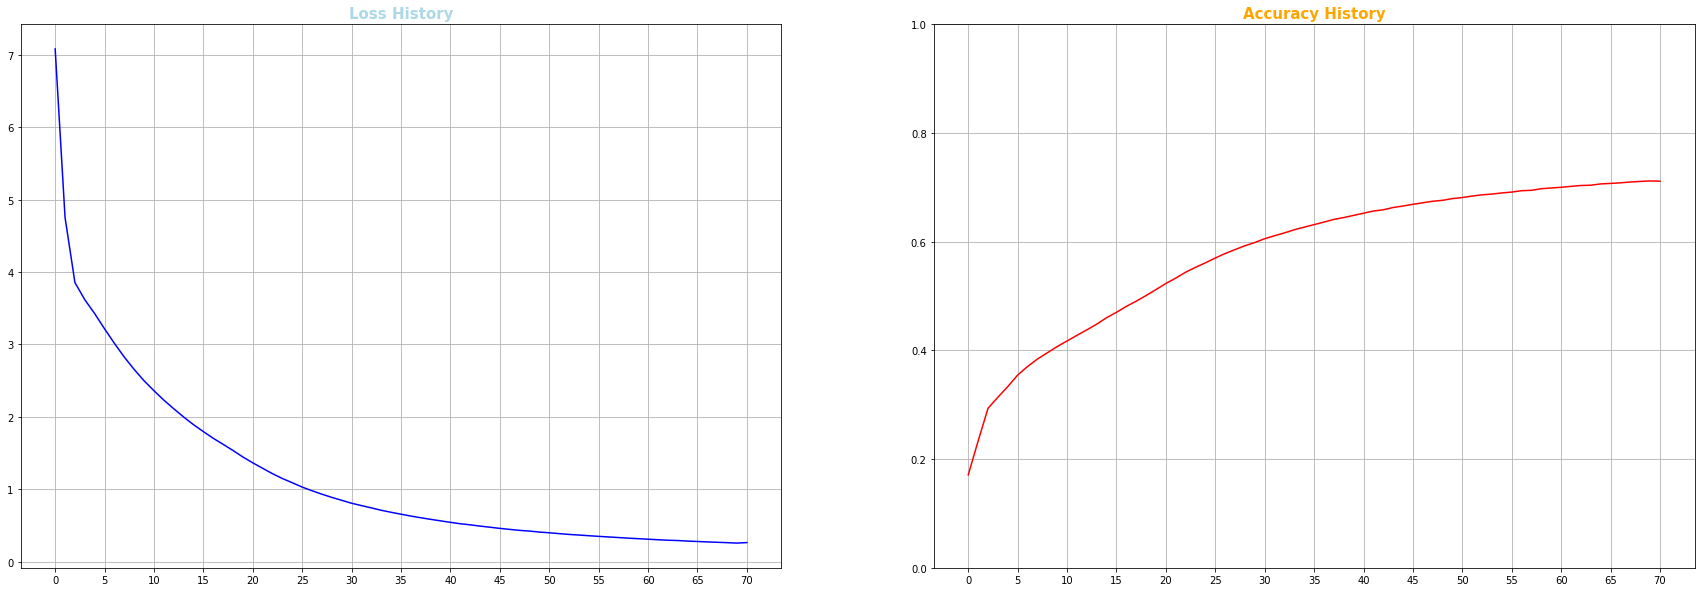

In [45]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plot loss and accuracy histories
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# loss history
loss_history = log['trainings']['comedy']['loss_history']
for i, loss in enumerate(loss_history):
  loss_history[i] = float(loss_history[i])

# accuracy history
acc_history = log['trainings']['comedy']['acc_history']
for i, loss in enumerate(acc_history):
  acc_history[i] = float(acc_history[i]) 

# plot loss history
ax0.set_title('Loss History', color='lightblue', fontsize=15, fontweight= 'bold')
ax0.set_xticks(range(0,len(loss_history),5))
ax0.grid()
ax0.plot(loss_history, color='blue')

# plot accuracy history
ax1.set_title('Accuracy History', color='orange', fontsize=15, fontweight= 'bold')
ax1.set_xticks(range(0,len(acc_history),5))
ax1.set_ylim(top=1)
ax1.grid()
ax1.plot(acc_history, color='red')